In [125]:
from __future__ import print_function, division

import numpy as np
import pandas as pd

from IPython.core.display import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

PATH = '/Users/ac/dsi-course-materials/curriculum/04-lessons/week-06/3.1-lesson/assets/datasets/'

# Boosting & Random Forests

## Learning Objectives

- Explain what a Random Forest is and how it is different from Bagging of Decision trees
- Explain what Extra Trees models are
- Apply both techniques to classification
- Describe Boosting and how it differs from Bagging
- Apply Adaboost and Gradient Boosting to classification problems

## Yesterday, we learned about bagging trees

## What is bagging?

> Bagging or bootstrap aggregration means pulling samples (with replacement) from our training data uniformly across our set of features

In [60]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap=plt.cm.gist_heat)
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.gist_heat)
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())
        
def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from IPython.html.widgets import interact
    return interact(interactive_tree, depth=[1, 10])

## All the data

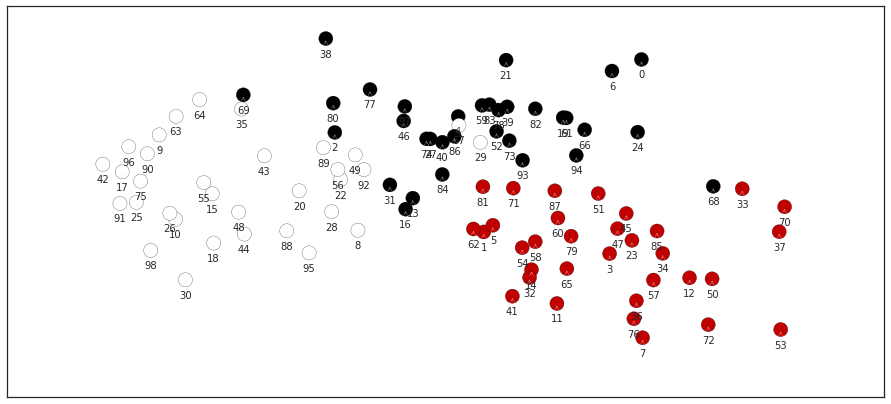

In [114]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()

X, y = make_blobs(n_samples=99, centers=3,
                  random_state=0, cluster_std=1)

labels = ['{0}'.format(i) for i in range(len(X))]

plt.scatter(X[:, 0], X[:, 1], c=y, s=200, cmap=plt.cm.gist_heat, edgecolors='k');
ax.set_xticks([]);
ax.set_yticks([]);

for label, x, yz in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label, 
        xy = (x, yz), xytext = (0, -10),
        textcoords = 'offset points', ha = 'center', va = 'top',
        bbox = dict(boxstyle = 'round, pad=0.3', alpha=0.0),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))

## With Bagging, one model sees this:

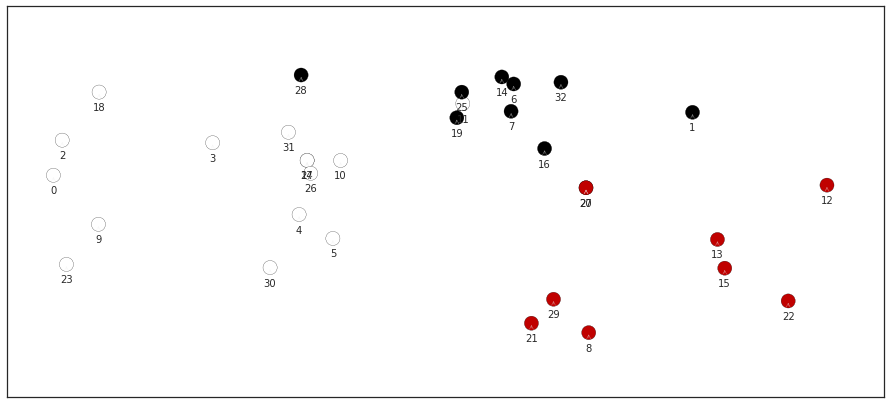

In [115]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()

sample_sz = int(np.floor(len(X)/3))
randz1 = np.random.randint(1, len(X), sample_sz)

Xrz1 = X[randz1,:]
y1 = y[randz1]


labels = ['{0}'.format(i) for i in range(len(X))]

plt.scatter(Xrz1[:, 0], Xrz1[:, 1], c=y1, s=200, cmap=plt.cm.gist_heat, edgecolors='k');
ax.set_xticks([]);
ax.set_yticks([]);

for label, x, yz in zip(labels, Xrz1[:, 0], Xrz1[:, 1]):
    plt.annotate(
        label, 
        xy = (x, yz), xytext = (0, -10),
        textcoords = 'offset points', ha = 'center', va = 'top',
        bbox = dict(boxstyle = 'round, pad=0.3', alpha=0.0),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))

## Another sees this:

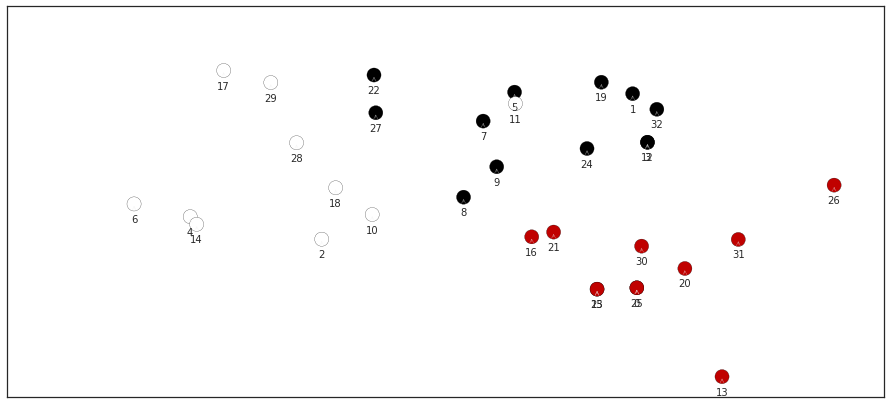

In [116]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()

sample_sz = int(np.floor(len(X)/3))
randz2 = np.random.randint(1, len(X), sample_sz)

Xrz2 = X[randz2,:]
y2 = y[randz2]

labels = ['{0}'.format(i) for i in range(len(X))]

plt.scatter(Xrz2[:, 0], Xrz2[:, 1], c=y2, s=200, cmap=plt.cm.gist_heat, edgecolors='k');
ax.set_xticks([]);
ax.set_yticks([]);

for label, x, yz in zip(labels, Xrz2[:, 0], Xrz2[:, 1]):
    plt.annotate(
        label, 
        xy = (x, yz), xytext = (0, -10),
        textcoords = 'offset points', ha = 'center', va = 'top',
        bbox = dict(boxstyle = 'round, pad=0.3', alpha=0.0),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))

## And another sees this:

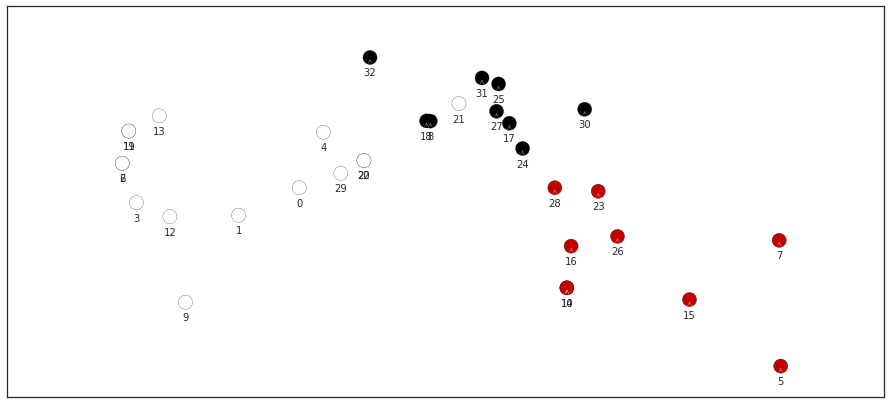

In [121]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()

sample_sz = int(np.floor(len(X)/3))
randz3 = np.random.randint(1, len(X), sample_sz)

Xrz3 = X[randz3,:]
y3 = y[randz3]


labels = ['{0}'.format(i) for i in range(len(X))]

plt.scatter(Xrz3[:, 0], Xrz3[:, 1], c=y3, s=200, cmap=plt.cm.gist_heat, edgecolors='k');
ax.set_xticks([]);
ax.set_yticks([]);

for label, x, yz in zip(labels, Xrz3[:, 0], Xrz3[:, 1]):
    plt.annotate(
        label, 
        xy = (x, yz), xytext = (0, -10),
        textcoords = 'offset points', ha = 'center', va = 'top',
        bbox = dict(boxstyle = 'round, pad=0.3', alpha=0.0),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'))

## In this example, with bagging, we would have 3 models each with their own prediction for given point. <br><br>The model would then use voting (classification) or averaging (regression) over all the models, to get the final result.

## But that is bagging trees. How is a Random Forest different?

A Random Forest not only uses sub-sampling, but also restrains the model by only giving it a **random sample of the total set of features with which to make a split on**. This is sometimes called feature bagging.

## Why do this?

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we counter this correlation between base trees, strengthening the overall model.

## What percent of the total features is seen in each split?

Typically, for a classification problem with $p$ features, $\sqrt{p}$ (rounded down) features are used in each split. For regression problems the inventors recommend $p/3$ (rounded down) with a minimum node size of 5 as the default.


## So, then a Random Forest looks something like this:

```python
for n in n_estimators:
    get a sub sample
    while depth < max_depth:
        select m predictors at random for the set of all p predictors (m < p)
        make optimal split at each node
```

## Can we get more random?

In [124]:
Image(url='http://www.kappit.com/img/pics/201511_2229_gagih.png')

## Yes, yes we can.

### Extremely Randomized Trees (ExtraTrees)

Adding one further step of randomization yields extremely randomized trees, or ExtraTrees. These are trained using bagging and the random subspace method, like in an ordinary random forest, but an additional layer of randomness is introduced. Instead of computing the locally optimal feature/split combination (based on, e.g., information gain or the Gini impurity), for each feature under consideration, a random value is selected for the split. This value is selected from the feature's empirical range (in the tree's training set, i.e., the bootstrap sample), in other words, the top-down splitting in the tree learner is randomized.

## Implementing the Classifiers in Scikit-Learn

## Load the Data

In [126]:
df = pd.read_csv(PATH + 'car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Pre-process the data

We will encode the features using **one hot encoding**, i.e. we will consider them as categorical variables. We also need to encode the label using the LabelEncoder.

In [130]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))

We would like to compare the performance of the following 4 algorithms:

- Decision Trees
- Bagging + Decision Trees
- Random Forest
- Extra Trees

Note that in order for our results to be consistent we have to expose the models to exactly the same Cross Validation scheme. Let's start by initializing that.

In [150]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=21)

In [151]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.967 ± 0.023


## Exercise: <br><br>Complete for the following models:

Initialize the following models and check their performance:

- Bagging + Decision Trees
- Random Forest
- Extra Trees

You can also create a function to speed up your work...

## Answer:

In [156]:
bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=100)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

def score(model, name):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

score(dt, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")

Decision Tree Score:	0.967 ± 0.023
Bagging DT Score:	0.978 ± 0.012
Random Forest Score:	0.963 ± 0.014
Extra Trees Score:	0.959 ± 0.017


# Boosting

In [158]:
Image(url='http://www.zianet.com/sundayt/images/srbsep03.jpg', width=400)

## What is Boosting?

Boosting is an iterative procedure that adaptively changes the sampling distribution of training records at each iteration in order to correct the errors of the previous iteration of models. The first iteration uses uniform weights (like bagging) for all samples. In subsequent iterations, the weights are adjusted to emphasize records that were misclassified in previous iterations. The final prediction is constructed by a weighted vote (where the weights for a base classifier depends on its training error).

## What is Boosting?

Since the base classifier's focus more and more closely on records that are difficult to classify as the sequence of iterations progresses, they are faced with progressively more difficult learning problems.

Boosting takes a **weak base learner** and tries to make it a strong learner by re-training it on the misclassified samples.

There are several algorithms for boosting, in particular we will mention AdaBoost, GradientBoostingClassifier that are implemented in scikit learn.

## Check: What is the difference between boosting and bagging?

>- Bagging is an unweighted aveage of simultaneous models
>- Boosting is a weighted average of sequential models

## AdaBoost

The core principle of AdaBoost is to **fit a sequence of weak learners** (i.e., models that are only slightly better than random guessing, such as small decision trees) **on repeatedly modified versions of the data**. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. 

The data **modifications** at each so-called boosting iteration **consist of applying weights $w_1, w_2, ..., w_N$ to each of the training samples**. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. 

For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. 

As iterations proceed, **examples that are difficult to predict receive ever-increasing influence**. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

## Gradient Boosting

Gradient Boosting is a generalization of boosting to arbitrary differentiable loss functions. 

Rather than re-weighting the data at each iteration, the model solves for the net loss of the prior model. That
is, each subsequent model fits the residuals of the last model.

The "gradient" in GB refers to the use of gradient of the loss function used to update the $\hat{y}$ in subsequent iterations. 

The ensemble then is the sum over all predictors weighted by the learning rate ($\alpha$).

## The key difference between the two?

- AdaBoost is about re-weighting the preceding model's errors in subsequent iterations 
- Gradient Boosting is about fitting subsequent models to the residuals of the last model

AdaBoost came first as a classification method and was generalized for regression with GB, but there are now implementations of classifiers and regressors for both AdaBoost and GB.

## Pros of Boosting:

- Typically give the best models in practice even besting deep learning in some cases
- Easy to apply a custom cost function that is directly optimized

## Check: What might be a downside to the models?

## Independent Practice:

Test the performance of the AdaBoost and GradientBoostingClassifier models on the car dataset. Use the code you developed above as a starter code.

## Answer:

In [160]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
score(ab, "AdaBoost")
score(gb, "Gradient Boosting Classifier")

AdaBoost Score:	0.838 ± 0.046
Gradient Boosting Classifier Score:	0.98 ± 0.011


## Conclusion

In this class we learned about Random Forest, extremely randomized trees (ExtraTrees), and Boosting. They are different ways to improve the performance of a weak learner.

Some of these methods will perform better in some cases, some better in other cases. For example, Decision Trees are more nimble and easier to communicate, but have a tendency to overfit. On the other hand ensemble methods perform better in more complex scenarios, but may become very complicated and harder to explain.